In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
#from torchnet.meter import AverageValueMeter
import torch.backends.cudnn as cudnn
from tqdm.notebook import tqdm, trange
from utils import depthToLogDepth

In [2]:
data_dir = Path("/home/michael/Desktop/projects/ROAR/data/output")
center_depth_dir = data_dir / "front_depth"
center_rgb_dir = data_dir / "front_rgb"
veh_state_dir = data_dir / "vehicle_state"

center_depth_paths = [p for p in sorted(center_depth_dir.glob("*.npy", ), key=os.path.getmtime)]
center_rgb_paths = [p for p in sorted(center_rgb_dir.glob("*.png", ), key=os.path.getmtime)]
veh_state_paths = [p for p in sorted(veh_state_dir.glob("*.npy", ), key=os.path.getmtime)]
assert len(center_depth_paths) == len(center_rgb_paths) == len(veh_state_paths)
print(f"Found { len(center_rgb_paths)} data points")

Found 118577 data points


In [3]:
steerings , throttles = [0]*len(center_depth_paths), [0]*len(center_depth_paths)
for i in tqdm(range(len(center_depth_paths))):
    state = np.load(veh_state_paths[i])
    steerings[i] = state[-1]
    throttles[i] = state[-2]
df = pd.DataFrame({"center_depth": center_depth_paths, "steering":steerings, "throttle": throttles})

  0%|          | 0/118577 [00:00<?, ?it/s]

In [4]:
df.head()

,center_depth,steering,throttle
0,/home/michael/Desktop/projects/ROAR/data/outpu...,0.053245,1.0
1,/home/michael/Desktop/projects/ROAR/data/outpu...,0.044596,1.0
2,/home/michael/Desktop/projects/ROAR/data/outpu...,0.035562,1.0
3,/home/michael/Desktop/projects/ROAR/data/outpu...,0.035561,1.0
4,/home/michael/Desktop/projects/ROAR/data/outpu...,0.035561,1.0


In [5]:
df.describe()

,steering,throttle
count,118577.000000,118577.000000
mean,-0.007236,0.604110
std,0.094685,0.345911
min,-0.640327,0.000000
25%,-0.068903,0.466233
50%,-0.006032,0.588960
75%,0.061620,1.000000
max,0.733144,1.000000


array([[<AxesSubplot:title={'center':'steering'}>,
        <AxesSubplot:title={'center':'throttle'}>]], dtype=object)

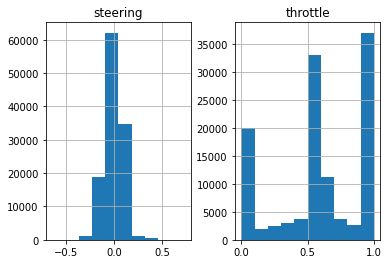

In [6]:
df.hist()

In [7]:
class CarDataset(torch.utils.data.Dataset):
    def __init__(self, df, should_use_log_depth=True, sigma = 0.1, thres_prob = 0.7, bin_sz = 0.05):
        self.df = df
        self.should_use_log_depth = should_use_log_depth
        
        self.sigma = sigma
        self.thres_prob = thres_prob
        self.bin_sz = bin_sz
    def calc_bin(self, rn):
        mult = round(1 / self.bin_sz)
        d = rn * mult // 1
        return d * self.bin_sz, (d + 1) * self.bin_sz
    
    def __getitem__(self, index):
        a = np.random.rand()
        if a > self.thres_prob:
            return self.get_item_helper(index)
        else:
            rn = np.random.normal(scale = self.sigma)
            low, high = self.calc_bin(rn)
            subset = self.df[(self.df["steering"] >= low) & (self.df["steering"] <= high)]
            # degenerate case :) ignore this
            if not len(subset):
                return self.get_item_helper(index)
            else:
                return self.get_item_helper(np.random.choice(subset.index))
    
    def get_item_helper(self, index):
#         path: Path = self.df.iloc[index]["center_depth"]
        path:Path = self.df["center_depth"][index]
        path_str = path.as_posix()
        depth_img = np.load(path_str)
        if self.should_use_log_depth:
            depth_img = depthToLogDepth(depth_img)

        steering = self.df["steering"][index]
        
        return depth_img, steering
        
    def __len__(self):
        return len(self.df)

In [8]:
train, valid = train_test_split(df, 
                                test_size=0.1, 
                                shuffle=True)
train = train.reset_index() 
valid = valid.reset_index()

array([[<AxesSubplot:title={'center':'steering'}>]], dtype=object)

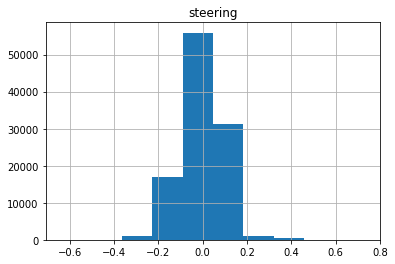

In [11]:
train.hist(["steering"])

array([[<AxesSubplot:title={'center':'steering'}>]], dtype=object)

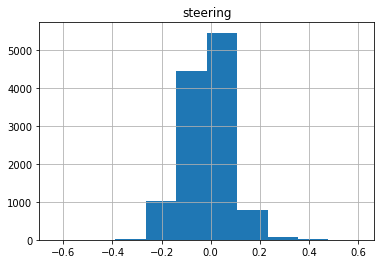

In [12]:
valid.hist(["steering"])

In [13]:
batch_size = 1
car_train_loader = DataLoader(CarDataset(df=train), 
                              batch_size=batch_size, shuffle=True)
car_valid_loader = DataLoader(CarDataset(df=valid), 
                              batch_size=batch_size, shuffle=True)

In [14]:
imgs, angles = next(iter(car_train_loader))
imgs.shape, angles.shape, len(car_train_loader)

(torch.Size([1, 600, 800]), torch.Size([1]), 106719)

In [15]:
from model import CarModel

In [16]:
def toTensor(data, use_cuda, device=None):
    img, target = data
#     img, target = torch.from_numpy(img).float(), torch.from_numpy(np.array([target])).float()
    img = img.float()
    target = target.float()
    if use_cuda:
        img, target = img.to(device), target.to(device)
    return img, target

In [17]:
best_loss = 1000000

def train(epoch, net, train_loader, optimizer, criterion, use_cuda, 
          device=None, save_dir=Path("."),MAX_BATCH=1000):
    net.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        img, steering_angle = toTensor(data, use_cuda, device)
        output = net(img) # Tensor([ITEM])
        loss = criterion(output, steering_angle)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        if batch_idx % 100 == 0:
            print(f'    Batch: {batch_idx} --> Loss: {train_loss / (batch_idx+1)}') 
        
        if batch_idx >= MAX_BATCH:
            break
    

def valid(epoch, net, validloader, criterion, use_cuda, device=None, save_dir=Path("."),MAX_BATCH=1000):
    global best_loss
    net.eval()
    valid_loss = 0 
    for batch_idx, data in enumerate(validloader):
        img, steering_angle = toTensor(data, use_cuda, device)
        outputs = net(img)
        loss = criterion(outputs, steering_angle)
        valid_loss += loss.data.item()
        
        avg_valid_loss = valid_loss / (batch_idx + 1)
        if batch_idx % 100 == 0:
            print(f"    Valid Loss: {avg_valid_loss}" )
        
        if avg_valid_loss <= best_loss:
            best_loss = avg_valid_loss
            print(f"         Saving.... Best epoch: {epoch} -> {avg_valid_loss}")
            torch.save(net.state_dict(),save_dir / "best_model_state_dict.h5" )
#             torch.save(net, save_dir / "best_model.h5")
        
        if batch_idx >= MAX_BATCH:
            break
    
    torch.save(net.state_dict(),save_dir / "model_state_dict.h5")


In [18]:
#load the previous net or use new net
# net = torch.load("/home/michael/Desktop/projects/ROAR/misc/data/best_model.h5")
# net.training = True

net = CarModel(batch_size=batch_size, 
              image_width=800,
              image_height=600)

/home/michael/anaconda3/envs/ROAR3.8/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [19]:
optimizer = optim.Adam(net.parameters(), lr=1e-5)
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

In [20]:
save_dir = Path("./data")
save_dir.mkdir(exist_ok=True, parents=True)
if use_cuda:
    net.to(device)
for epoch in range(0, 10):
    print(f"Epoch {epoch}")
    train(epoch, net, car_train_loader, optimizer, criterion, use_cuda, device=device, save_dir=save_dir, 
          MAX_BATCH=len(car_train_loader)//4)
    valid(epoch, net, car_valid_loader, criterion, use_cuda, device=device, save_dir=save_dir, MAX_BATCH=1000)

Epoch 0
    Batch: 0 --> Loss: 0.014868524856865406
    Batch: 100 --> Loss: 0.037118387965370175
    Batch: 200 --> Loss: 0.03207724473569312
    Batch: 300 --> Loss: 0.026898221439581104
    Batch: 400 --> Loss: 0.022965004514613918
    Batch: 500 --> Loss: 0.02027678732027382
    Batch: 600 --> Loss: 0.018090973884155304
    Batch: 700 --> Loss: 0.01644222891158719
    Batch: 800 --> Loss: 0.015089117767316156
    Batch: 900 --> Loss: 0.013923087677359601
    Batch: 1000 --> Loss: 0.01284694781097009
    Batch: 1100 --> Loss: 0.012092366124692768
    Batch: 1200 --> Loss: 0.011452500039403745
    Batch: 1300 --> Loss: 0.01083808449675266
    Batch: 1400 --> Loss: 0.010316325334941185
    Batch: 1500 --> Loss: 0.009864319206597489
    Batch: 1600 --> Loss: 0.009545704631328167
    Batch: 1700 --> Loss: 0.009312734238996857
    Batch: 1800 --> Loss: 0.009154030005917432
    Batch: 1900 --> Loss: 0.008872691129857252
    Batch: 2000 --> Loss: 0.00866341616183306
    Batch: 2100 --> Los

    Batch: 17400 --> Loss: 0.004063192477394124
    Batch: 17500 --> Loss: 0.004059433692370118
    Batch: 17600 --> Loss: 0.004051616706209826
    Batch: 17700 --> Loss: 0.004044347513255152
    Batch: 17800 --> Loss: 0.004033338205808996
    Batch: 17900 --> Loss: 0.004025029215757206
    Batch: 18000 --> Loss: 0.0040134528801951085
    Batch: 18100 --> Loss: 0.00400165850158412
    Batch: 18200 --> Loss: 0.003987773460798886
    Batch: 18300 --> Loss: 0.003979798716519079
    Batch: 18400 --> Loss: 0.003972630658404715
    Batch: 18500 --> Loss: 0.003961074014993103
    Batch: 18600 --> Loss: 0.003948019093613001
    Batch: 18700 --> Loss: 0.003939528183860203
    Batch: 18800 --> Loss: 0.003934708700223811
    Batch: 18900 --> Loss: 0.003925685288462468
    Batch: 19000 --> Loss: 0.003915091334397446
    Batch: 19100 --> Loss: 0.0039053769944449837
    Batch: 19200 --> Loss: 0.0039016629909102833
    Batch: 19300 --> Loss: 0.0038944226015625483
    Batch: 19400 --> Loss: 0.00389430

    Batch: 5100 --> Loss: 0.002094227055630997
    Batch: 5200 --> Loss: 0.0020924091662036766
    Batch: 5300 --> Loss: 0.0021009309726319337
    Batch: 5400 --> Loss: 0.0021128773201641005
    Batch: 5500 --> Loss: 0.0021432711773610434
    Batch: 5600 --> Loss: 0.0021457968282768804
    Batch: 5700 --> Loss: 0.002136531827673116
    Batch: 5800 --> Loss: 0.0021395792400534983
    Batch: 5900 --> Loss: 0.002163821591637117
    Batch: 6000 --> Loss: 0.0021461104021561067
    Batch: 6100 --> Loss: 0.002128375095395765
    Batch: 6200 --> Loss: 0.002145480189137258
    Batch: 6300 --> Loss: 0.0021632302127323278
    Batch: 6400 --> Loss: 0.002162625072633514
    Batch: 6500 --> Loss: 0.00215922607252857
    Batch: 6600 --> Loss: 0.002157545761777538
    Batch: 6700 --> Loss: 0.002152472451411649
    Batch: 6800 --> Loss: 0.0021506753406327975
    Batch: 6900 --> Loss: 0.0021539151002436204
    Batch: 7000 --> Loss: 0.0021523847924025405
    Batch: 7100 --> Loss: 0.002160717253803985
   

    Batch: 22100 --> Loss: 0.002032114772656265
    Batch: 22200 --> Loss: 0.0020321515426863237
    Batch: 22300 --> Loss: 0.0020284649090510174
    Batch: 22400 --> Loss: 0.002027654387940406
    Batch: 22500 --> Loss: 0.0020275047052004907
    Batch: 22600 --> Loss: 0.002028777701769208
    Batch: 22700 --> Loss: 0.002029518373538526
    Batch: 22800 --> Loss: 0.00203108963929457
    Batch: 22900 --> Loss: 0.002029240144161679
    Batch: 23000 --> Loss: 0.0020286128773773626
    Batch: 23100 --> Loss: 0.0020256412294021044
    Batch: 23200 --> Loss: 0.0020238955841726954
    Batch: 23300 --> Loss: 0.00202047681437776
    Batch: 23400 --> Loss: 0.0020267776756666953
    Batch: 23500 --> Loss: 0.0020302294471139203
    Batch: 23600 --> Loss: 0.0020279273109853713
    Batch: 23700 --> Loss: 0.0020247050307218273
    Batch: 23800 --> Loss: 0.0020225172394842473
    Batch: 23900 --> Loss: 0.002022354704017242
    Batch: 24000 --> Loss: 0.0020207422046224295
    Batch: 24100 --> Loss: 0.0

    Batch: 11600 --> Loss: 0.0017113108724461747
    Batch: 11700 --> Loss: 0.0017110327363134344
    Batch: 11800 --> Loss: 0.0017080140933929463
    Batch: 11900 --> Loss: 0.0017056843800515118
    Batch: 12000 --> Loss: 0.0017043499069843877
    Batch: 12100 --> Loss: 0.0017027173631580404
    Batch: 12200 --> Loss: 0.0017013390618736115
    Batch: 12300 --> Loss: 0.0017088127293480649
    Batch: 12400 --> Loss: 0.001704917636676713
    Batch: 12500 --> Loss: 0.0017018472864452812
    Batch: 12600 --> Loss: 0.0017099954804678178
    Batch: 12700 --> Loss: 0.0017067777183547978
    Batch: 12800 --> Loss: 0.0017053652936207732
    Batch: 12900 --> Loss: 0.0017043389586705354
    Batch: 13000 --> Loss: 0.0017012269465125972
    Batch: 13100 --> Loss: 0.0016999073641354521
    Batch: 13200 --> Loss: 0.0016970829192964612
    Batch: 13300 --> Loss: 0.0016928790280415866
    Batch: 13400 --> Loss: 0.0016920258351483394
    Batch: 13500 --> Loss: 0.001689013151309062
    Batch: 13600 --> L

    Batch: 800 --> Loss: 0.0014711534786916868
    Batch: 900 --> Loss: 0.0014692673675883517
    Batch: 1000 --> Loss: 0.001419715754140716
    Batch: 1100 --> Loss: 0.0013812836214983934
    Batch: 1200 --> Loss: 0.0013775218150964639
    Batch: 1300 --> Loss: 0.0014369937389791564
    Batch: 1400 --> Loss: 0.0015629547437248073
    Batch: 1500 --> Loss: 0.0017083389963350967
    Batch: 1600 --> Loss: 0.001716494621376469
    Batch: 1700 --> Loss: 0.0016978882091637523
    Batch: 1800 --> Loss: 0.001657376666489428
    Batch: 1900 --> Loss: 0.0016609239441913838
    Batch: 2000 --> Loss: 0.0016167925882532724
    Batch: 2100 --> Loss: 0.0015843751362493953
    Batch: 2200 --> Loss: 0.0015892260898055302
    Batch: 2300 --> Loss: 0.001577999283326145
    Batch: 2400 --> Loss: 0.0015970671533765749
    Batch: 2500 --> Loss: 0.001594085360765338
    Batch: 2600 --> Loss: 0.0016289644974107605
    Batch: 2700 --> Loss: 0.0015961800483018731
    Batch: 2800 --> Loss: 0.0015678711937449387

    Batch: 17900 --> Loss: 0.001567234644404538
    Batch: 18000 --> Loss: 0.0015652172191572469
    Batch: 18100 --> Loss: 0.0015659362250209198
    Batch: 18200 --> Loss: 0.001564303659938316
    Batch: 18300 --> Loss: 0.0015608395964125446
    Batch: 18400 --> Loss: 0.0015731962325125544
    Batch: 18500 --> Loss: 0.001573395158345566
    Batch: 18600 --> Loss: 0.001572820488134044
    Batch: 18700 --> Loss: 0.0015738479605375685
    Batch: 18800 --> Loss: 0.0015747743834098461
    Batch: 18900 --> Loss: 0.0015725617015910803
    Batch: 19000 --> Loss: 0.0015695805247280736
    Batch: 19100 --> Loss: 0.0015698463354929446
    Batch: 19200 --> Loss: 0.0015829271933722972
    Batch: 19300 --> Loss: 0.001585870377838282
    Batch: 19400 --> Loss: 0.0015851073791146738
    Batch: 19500 --> Loss: 0.001585811735531421
    Batch: 19600 --> Loss: 0.0015830984771585583
    Batch: 19700 --> Loss: 0.001579458050222937
    Batch: 19800 --> Loss: 0.0015755245274619329
    Batch: 19900 --> Loss: 

    Batch: 7200 --> Loss: 0.0014397913454484595
    Batch: 7300 --> Loss: 0.0014434966787783589
    Batch: 7400 --> Loss: 0.0014380452330744057
    Batch: 7500 --> Loss: 0.0014425300553738798
    Batch: 7600 --> Loss: 0.0014416867548330595
    Batch: 7700 --> Loss: 0.00145072182425429
    Batch: 7800 --> Loss: 0.0014477784087184266
    Batch: 7900 --> Loss: 0.0014801393230766803
    Batch: 8000 --> Loss: 0.0014959085919595502
    Batch: 8100 --> Loss: 0.0014980137518719868
    Batch: 8200 --> Loss: 0.0015006507964106823
    Batch: 8300 --> Loss: 0.0014961630688123853
    Batch: 8400 --> Loss: 0.0014907265230881773
    Batch: 8500 --> Loss: 0.0014897746888365506
    Batch: 8600 --> Loss: 0.0014826822001913484
    Batch: 8700 --> Loss: 0.0014792238825851903
    Batch: 8800 --> Loss: 0.0014830833950989848
    Batch: 8900 --> Loss: 0.0014788535037829921
    Batch: 9000 --> Loss: 0.001480790977071447
    Batch: 9100 --> Loss: 0.0014750329590163388
    Batch: 9200 --> Loss: 0.001484711033072

    Batch: 24100 --> Loss: 0.0014960523893061022
    Batch: 24200 --> Loss: 0.0014953746669767584
    Batch: 24300 --> Loss: 0.0014963050402945596
    Batch: 24400 --> Loss: 0.0014958135701882698
    Batch: 24500 --> Loss: 0.0014961284585372813
    Batch: 24600 --> Loss: 0.0014944408218299512
    Batch: 24700 --> Loss: 0.0014915132228899117
    Batch: 24800 --> Loss: 0.0014904543935344474
    Batch: 24900 --> Loss: 0.0014960213189622177
    Batch: 25000 --> Loss: 0.001497046823266784
    Batch: 25100 --> Loss: 0.0014949325767099095
    Batch: 25200 --> Loss: 0.0014938184390832642
    Batch: 25300 --> Loss: 0.0014914830838053171
    Batch: 25400 --> Loss: 0.0014917547685806044
    Batch: 25500 --> Loss: 0.0014930243213561757
    Batch: 25600 --> Loss: 0.0014951716391903766
    Batch: 25700 --> Loss: 0.0014976697797640587
    Batch: 25800 --> Loss: 0.00150006772176332
    Batch: 25900 --> Loss: 0.001499106403991372
    Batch: 26000 --> Loss: 0.0014979416445180876
    Batch: 26100 --> Los

    Batch: 13600 --> Loss: 0.0014908155895943243
    Batch: 13700 --> Loss: 0.0014863510722302887
    Batch: 13800 --> Loss: 0.0014817928800838606
    Batch: 13900 --> Loss: 0.0014810598163052912
    Batch: 14000 --> Loss: 0.00147637103099973
    Batch: 14100 --> Loss: 0.0014779090264018333
    Batch: 14200 --> Loss: 0.0014867561352593127
    Batch: 14300 --> Loss: 0.0014834070957240432
    Batch: 14400 --> Loss: 0.0014837874505417641
    Batch: 14500 --> Loss: 0.001490361870830628
    Batch: 14600 --> Loss: 0.0015064976806057988
    Batch: 14700 --> Loss: 0.001506785516928536
    Batch: 14800 --> Loss: 0.0015047784093353484
    Batch: 14900 --> Loss: 0.001512762702579655
    Batch: 15000 --> Loss: 0.0015115559389289992
    Batch: 15100 --> Loss: 0.0015119924861975939
    Batch: 15200 --> Loss: 0.0015123976364928592
    Batch: 15300 --> Loss: 0.00150853309165857
    Batch: 15400 --> Loss: 0.0015064174991451702
    Batch: 15500 --> Loss: 0.0015031603953236687
    Batch: 15600 --> Loss: 

    Batch: 2900 --> Loss: 0.0013738684942077087
    Batch: 3000 --> Loss: 0.0013705876425265506
    Batch: 3100 --> Loss: 0.0013729445663505455
    Batch: 3200 --> Loss: 0.0013582912540909284
    Batch: 3300 --> Loss: 0.0013553036287210804
    Batch: 3400 --> Loss: 0.00134316650984929
    Batch: 3500 --> Loss: 0.0013417072551125822
    Batch: 3600 --> Loss: 0.00133077072933804
    Batch: 3700 --> Loss: 0.0013201872529458245
    Batch: 3800 --> Loss: 0.0013191684149746411
    Batch: 3900 --> Loss: 0.0013068976969516665
    Batch: 4000 --> Loss: 0.0012944830696731498
    Batch: 4100 --> Loss: 0.0012850289470775194
    Batch: 4200 --> Loss: 0.0012903160369414403
    Batch: 4300 --> Loss: 0.0012917517430287985
    Batch: 4400 --> Loss: 0.0012984368045918335
    Batch: 4500 --> Loss: 0.0012884887314572933
    Batch: 4600 --> Loss: 0.0012918325600871023
    Batch: 4700 --> Loss: 0.0012983087602260943
    Batch: 4800 --> Loss: 0.0012931215391848623
    Batch: 4900 --> Loss: 0.0012909559715187

    Batch: 19900 --> Loss: 0.001339034752414447
    Batch: 20000 --> Loss: 0.001337922350964244
    Batch: 20100 --> Loss: 0.0013359865700562376
    Batch: 20200 --> Loss: 0.0013333089568639662
    Batch: 20300 --> Loss: 0.0013316631927090036
    Batch: 20400 --> Loss: 0.0013302629433836733
    Batch: 20500 --> Loss: 0.001329621735349745
    Batch: 20600 --> Loss: 0.001328977619988652
    Batch: 20700 --> Loss: 0.0013277701791985187
    Batch: 20800 --> Loss: 0.0013261054473089
    Batch: 20900 --> Loss: 0.001324593463081166
    Batch: 21000 --> Loss: 0.001321756822206199
    Batch: 21100 --> Loss: 0.0013200134722942294
    Batch: 21200 --> Loss: 0.0013189541034223059
    Batch: 21300 --> Loss: 0.0013167351546963663
    Batch: 21400 --> Loss: 0.0013156821451542828
    Batch: 21500 --> Loss: 0.0013140213281666352
    Batch: 21600 --> Loss: 0.0013114086416295167
    Batch: 21700 --> Loss: 0.0013124613893131824
    Batch: 21800 --> Loss: 0.0013109353994743464
    Batch: 21900 --> Loss: 0.

    Batch: 9400 --> Loss: 0.0013045194434225678
    Batch: 9500 --> Loss: 0.0013033235857774002
    Batch: 9600 --> Loss: 0.0013103356869156092
    Batch: 9700 --> Loss: 0.0013144843731809944
    Batch: 9800 --> Loss: 0.0013281916540405525
    Batch: 9900 --> Loss: 0.0013278472495374953
    Batch: 10000 --> Loss: 0.0013241411503351849
    Batch: 10100 --> Loss: 0.0013323378244992636
    Batch: 10200 --> Loss: 0.001340096539233728
    Batch: 10300 --> Loss: 0.0013417215978122157
    Batch: 10400 --> Loss: 0.0013381216547907837
    Batch: 10500 --> Loss: 0.0013362764136107578
    Batch: 10600 --> Loss: 0.0013310545401469392
    Batch: 10700 --> Loss: 0.001328015892301901
    Batch: 10800 --> Loss: 0.0013250378051410747
    Batch: 10900 --> Loss: 0.0013258970067847211
    Batch: 11000 --> Loss: 0.0013238970790660019
    Batch: 11100 --> Loss: 0.0013217549574513921
    Batch: 11200 --> Loss: 0.0013196757287612614
    Batch: 11300 --> Loss: 0.0013155154139376831
    Batch: 11400 --> Loss: 0

    Batch: 26300 --> Loss: 0.0013497356644668896
    Batch: 26400 --> Loss: 0.001349266429810431
    Batch: 26500 --> Loss: 0.0013483821660530805
    Batch: 26600 --> Loss: 0.001345947065150621
    Valid Loss: 9.926814527716488e-06
         Saving.... Best epoch: 7 -> 9.926814527716488e-06
    Valid Loss: 0.0011056160786843447
    Valid Loss: 0.0011559847873265784
    Valid Loss: 0.001220055002132364
    Valid Loss: 0.0013706424175542633
    Valid Loss: 0.001346613454636462
    Valid Loss: 0.0014283347998663117
    Valid Loss: 0.00132251021437916
    Valid Loss: 0.0012386907303553348
    Valid Loss: 0.0012414004706584492
    Valid Loss: 0.00121107847858223
Epoch 8
    Batch: 0 --> Loss: 1.6842965123942122e-05
    Batch: 100 --> Loss: 0.0009771013714561657
    Batch: 200 --> Loss: 0.0012312616616141348
    Batch: 300 --> Loss: 0.0012874185528620537
    Batch: 400 --> Loss: 0.0012435524863328748
    Batch: 500 --> Loss: 0.0012284147283051327
    Batch: 600 --> Loss: 0.0011806435823472012

    Batch: 15700 --> Loss: 0.0012692399272459071
    Batch: 15800 --> Loss: 0.0012676235845910655
    Batch: 15900 --> Loss: 0.0012642155910053193
    Batch: 16000 --> Loss: 0.001265615983771232
    Batch: 16100 --> Loss: 0.0012629262163657052
    Batch: 16200 --> Loss: 0.0012604190383442558
    Batch: 16300 --> Loss: 0.0012598028621380432
    Batch: 16400 --> Loss: 0.001259419304387819
    Batch: 16500 --> Loss: 0.0012582042564619213
    Batch: 16600 --> Loss: 0.0012546761190093507
    Batch: 16700 --> Loss: 0.001255278165043036
    Batch: 16800 --> Loss: 0.001256549677325866
    Batch: 16900 --> Loss: 0.0012652531106546324
    Batch: 17000 --> Loss: 0.001262065236948635
    Batch: 17100 --> Loss: 0.0012613241799268044
    Batch: 17200 --> Loss: 0.0012622267325065582
    Batch: 17300 --> Loss: 0.0012591521739046567
    Batch: 17400 --> Loss: 0.0012632396160326574
    Batch: 17500 --> Loss: 0.001265632351055623
    Batch: 17600 --> Loss: 0.0012659257472991952
    Batch: 17700 --> Loss:

    Batch: 5100 --> Loss: 0.0013108235865979673
    Batch: 5200 --> Loss: 0.0013136934446929547
    Batch: 5300 --> Loss: 0.00130477188935486
    Batch: 5400 --> Loss: 0.001316003798910225
    Batch: 5500 --> Loss: 0.0013623623695891748
    Batch: 5600 --> Loss: 0.0013540696009014157
    Batch: 5700 --> Loss: 0.0013466657364704288
    Batch: 5800 --> Loss: 0.0013474748825874517
    Batch: 5900 --> Loss: 0.0013784116056989573
    Batch: 6000 --> Loss: 0.0013762853117147496
    Batch: 6100 --> Loss: 0.0013714799614763511
    Batch: 6200 --> Loss: 0.0013573213807758495
    Batch: 6300 --> Loss: 0.001350736105657182
    Batch: 6400 --> Loss: 0.0013471125669244517
    Batch: 6500 --> Loss: 0.0013429242126005193
    Batch: 6600 --> Loss: 0.0013436070271254036
    Batch: 6700 --> Loss: 0.0013454153939563454
    Batch: 6800 --> Loss: 0.0013413648902271982
    Batch: 6900 --> Loss: 0.0013400387687769488
    Batch: 7000 --> Loss: 0.0013370901731692582
    Batch: 7100 --> Loss: 0.0013458126807097

    Batch: 22100 --> Loss: 0.0013027557914750245
    Batch: 22200 --> Loss: 0.0013027859412259504
    Batch: 22300 --> Loss: 0.0013007194008305735
    Batch: 22400 --> Loss: 0.0013014367755914504
    Batch: 22500 --> Loss: 0.001299701710785822
    Batch: 22600 --> Loss: 0.0012970540226980192
    Batch: 22700 --> Loss: 0.0012954933125475395
    Batch: 22800 --> Loss: 0.0012932250931726981
    Batch: 22900 --> Loss: 0.0012917726746953264
    Batch: 23000 --> Loss: 0.0012919282018449588
    Batch: 23100 --> Loss: 0.001292314390550176
    Batch: 23200 --> Loss: 0.0012928203144340349
    Batch: 23300 --> Loss: 0.0012936822245756035
    Batch: 23400 --> Loss: 0.001296043116606716
    Batch: 23500 --> Loss: 0.0012972772293882403
    Batch: 23600 --> Loss: 0.0012958308550349304
    Batch: 23700 --> Loss: 0.0012950376237233733
    Batch: 23800 --> Loss: 0.0012926144235098328
    Batch: 23900 --> Loss: 0.001289868756903895
    Batch: 24000 --> Loss: 0.0012891414090565408
    Batch: 24100 --> Los

In [ ]:
b    